In [1]:
# Exploring the covariance in segregating sites
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import warnings
warnings.filterwarnings("ignore")

import re

import os
import sys
sys.path.append('../../src/')
from plot_utils import *

from tqdm import tqdm
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
from geopy.distance import geodesic

from patsy import dmatrices
from statsmodels.api import OLS

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE : this should be from the plot utils 
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 3
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker


main_figdir = '../../plots/hap_copying/jump_rate_chrXdata/'
supp_figdir = '../../plots/supp_figs/hap_copying/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

%matplotlib inline

## Obtaining Raw Statistics from a 1KG Panel

In [3]:
total_raw_stats_df = pd.read_csv('../../results/hap_copying/chrX_male_analysis/mle_est_real_1kg/chrX_filt.total.ls_stats.merged.csv')
total_raw_stats_df.head(5)

,indivID,Country,Location,Lat,Long,AvgDate_calBP,Sex,Cov_Autosomes,Data_Type,Publication,...,panelID,scale_marginal,se_marginal,se_scale_marginal_fd,scale_jt,se_scale_jt,eps_jt,se_eps_jt,nsnps,nref_haps
0,I0172,Germany,Esperstedt,51.42,11.68,5173.0,M,25.372,1240K,MathiesonNature2015 (1240k of same same sample...,...,ceu,445.274956,3.982112,3.971789,414.761336,3.625205,0.004298,0.000113,22919,49
1,I0172,Germany,Esperstedt,51.42,11.68,5173.0,M,25.372,1240K,MathiesonNature2015 (1240k of same same sample...,...,eur,246.763477,1.149983,1.150651,243.505637,34.648345,0.001696,0.000853,26103,240
2,I0172,Germany,Esperstedt,51.42,11.68,5173.0,M,25.372,1240K,MathiesonNature2015 (1240k of same same sample...,...,fullkg,189.884152,0.413236,0.411298,185.781447,0.319851,0.001817,0.000012,35889,1233
3,Loschbour_snpAD.DG,Luxembourg,Echternach,49.81,6.40,8050.0,M,22.000,Shotgun.diploid,Pruefer2017,...,ceu,414.610688,3.855402,3.800422,400.689829,138.162974,0.002128,0.001628,25426,49
4,Loschbour_snpAD.DG,Luxembourg,Echternach,49.81,6.40,8050.0,M,22.000,Shotgun.diploid,Pruefer2017,...,eur,241.639812,1.101647,1.098853,243.994774,360.262569,0.000461,0.003016,28922,240


In [4]:
def quality_control_panel_select(df, panel='ceu', nsnps=8000, dups=True):
    """Filter the data frame by the panel"""
    pass_indices = np.array(['PASS' in df['Assessment'].values[i] for i in range(df.shape[0])])
    pass_indivs_raw = df.iloc[np.where(pass_indices)[0]]
    pass_indivs_filt_nsnps = pass_indivs_raw[(pass_indivs_raw['nsnps'] >= nsnps)]
    pass_indivs = pass_indivs_filt_nsnps[pass_indivs_filt_nsnps.panelID == panel]
    if dups:
        ids = []
        for i in pass_indivs.indivID.unique():
            ids.append(re.split('_|\.SG|\.DG', i)[0])

        pass_indivs['true_id'] = ids
        pass_indivs = pass_indivs.sort_values('Cov_Autosomes', ascending=False).drop_duplicates(['true_id'])
    return(pass_indivs)


def spatial_restrict(df, x=48., y=6., km_thresh=1500., age_thresh=1.5e4):
    """Restrict to samples with a given Lat/Long within a distance from a centroid."""
    
    global_lats = df.Lat
    global_longs = df.Long
    idx = (global_lats != '..') & (global_longs != '..')
    test_longs = global_longs[idx].values.astype(float)
    test_lats = global_lats[idx].values.astype(float)

    assert(test_longs.size == test_lats.size)

    # Setting coordinates for the middle of Europe
    centroid_coords = (x, y)
    geo_dist_centroid = np.zeros(test_longs.size)
    for i in range(test_longs.size):
        geo_dist_centroid[i] = geodesic(centroid_coords, (test_lats[i], test_longs[i])).kilometers

    # Putting in the distances from centroid here ... 
    dist = np.zeros(df.shape[0])
    dist[idx] = geo_dist_centroid
    df['centroid_dist'] = dist
    
    filt_df = df[(df.centroid_dist != 0) & (df.centroid_dist <= km_thresh) & (df.AvgDate_calBP <= 1.5e4)]
    filt_df = filt_df.astype({'Lat': 'float64', 'Long': 'float64', 'AvgDate_calBP': 'float64', 'Cov_Autosomes': 'float64'})
    return(filt_df)

In [5]:
# Do a little filtering on the number of snps per kb
snps_total = 49704
tot_len = 155234382 - 990180
nsnps = 8000
snps_per_kb = nsnps  / (tot_len / 1e3)

# options for panel: (ceu|eur|fullkg)
panel = 'ceu'

# Make sure the individuals "PASS" according to the Reich-Lab assessment
pass_indivs = quality_control_panel_select(total_raw_stats_df, panel=panel, nsnps=nsnps);
# NOTE: should have a way to filter duplicate samples (and only take the higher coverage sample ... )
pass_indivs.head()
print(nsnps, snps_per_kb, snps_per_kb*25, pass_indivs.shape[0])

8000 0.05186580692349137 1.296645173087284 344


3.0218699040697676 2.906627422504752 2.3082450000000003 344


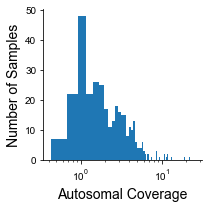

In [6]:
cov_auto = pass_indivs['Cov_Autosomes']
print(np.nanmean(cov_auto), np.nanstd(cov_auto), np.median(cov_auto), cov_auto.size)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.hist(cov_auto, bins=100);
debox(ax);
ax.set_xscale('log')
ax.set_xlabel(r'Autosomal Coverage', fontsize=14);
ax.set_ylabel(r'Number of Samples', fontsize=14);

In [7]:
mean_age = pass_indivs.groupby('Country').mean()['AvgDate_calBP']
std_age = pass_indivs.groupby('Country').std()['AvgDate_calBP']
min_age = pass_indivs.groupby('Country')['AvgDate_calBP'].min()
max_age = pass_indivs.groupby('Country')['AvgDate_calBP'].max()

In [8]:
global_lats = pass_indivs.Lat
global_longs = pass_indivs.Long
global_lambda = pass_indivs.scale_marginal
global_lambda_se = pass_indivs.se_scale_marginal_fd
global_age = pass_indivs.AvgDate_calBP
idx = (global_lats != '..') & (global_longs != '..') & (global_lambda < 1e4) & (global_age < 2e4)

In [9]:
# Calculate Distance from central europe (ideally add as another annotation)
test_longs = global_longs[idx].values.astype(float)
test_lats = global_lats[idx].values.astype(float)
test_lambda = global_lambda[idx].values.astype(float)
test_lambda_se = global_lambda_se[idx].values.astype(float)
test_ages = global_age[idx].values.astype(float)

assert(test_longs.size == test_lats.size)
assert(test_longs.size == test_lambda.size)

# Setting coordinates for the middle of Europe
ceu_coords = (48., 6.)
geo_dist_ceu = np.zeros(test_longs.size)
for i in tqdm(range(test_longs.size)):
    geo_dist_ceu[i] = geodesic(ceu_coords, (test_lats[i], test_longs[i])).kilometers
    
# Putting in the distances from CEU coordinates here ... 
dist = np.zeros(pass_indivs.shape[0])
dist[idx] = geo_dist_ceu
pass_indivs['CEU_dist'] = dist

100%|██████████| 344/344 [00:00<00:00, 2773.81it/s]


344
                             0           1
Intercept           531.797429  680.577487
AvgDateGenerations   -0.607300   -0.444764
Lat                  -3.181494   -0.191678
Long                  7.230048   21.648044
Lat:Long             -0.424144   -0.127913
606.1874580716019 -0.5260316866436665 1.2890955212357306e-30


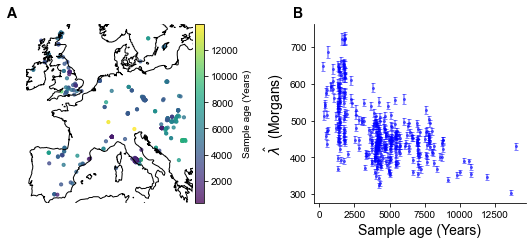

In [10]:
#Do the slight filtering here ... 
km_thresh = 1500
gen_time = 30.
test_df = pass_indivs[(pass_indivs.CEU_dist != 0) & (pass_indivs.CEU_dist <= km_thresh) & (pass_indivs.AvgDate_calBP <= 1.5e4)]
test_df = test_df.astype({'Lat': 'float64', 'Long': 'float64', 'AvgDate_calBP': 'float64', 'Cov_Autosomes': 'float64'})
test_df['AvgDateGenerations'] = test_df.AvgDate_calBP.values / gen_time 

print(test_df.shape[0])

fig = plt.figure(figsize=(7.5,3.5))
gs = fig.add_gridspec(1, 6)


age_gen = test_df.AvgDateGenerations.values.astype(float)
age_years = test_df.AvgDate_calBP.values.astype(float)

ax1 = fig.add_subplot(gs[:, :3], projection=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k')
im = ax1.scatter(test_df.Long.values.astype(float), 
           test_df.Lat.values.astype(float),
           transform=ccrs.PlateCarree(), c=age_years, s=10, alpha=0.75, rasterized=True)

fig.colorbar(im, ax=ax1, orientation='vertical', pad=0.01, fraction=0.2, label=r'Sample age (Years)')

ax1.set_aspect('auto')
ax1.outline_patch.set_visible(False)
debox(ax1);


# Linear Model to check for effect of age 
y, X = dmatrices('scale_marginal ~ AvgDateGenerations + Lat + Long + Lat:Long', 
                 data=test_df,
                 return_type='dataframe')

res = sm.OLS(y,X).fit()
# print(res.summary())
intercept = res.params['Intercept']
beta_age = res.params['AvgDateGenerations']
p_value = res.pvalues['AvgDateGenerations']
print(res.conf_int(alpha=0.05))

marginal_lambda = test_df.scale_marginal.values
marginal_lambda_se = test_df.se_scale_marginal_fd.values

ax3 = fig.add_subplot(gs[:, 3:])
im2 = ax3.errorbar(rand_jitter(age_years, scale=1e-3), marginal_lambda, 
                   yerr=2*marginal_lambda_se,  color='blue', alpha=0.5, 
                   linestyle='none', markersize=2, marker='o', capsize=2)

# Print out the results of the linear regression
print(intercept, beta_age, p_value)

ax3.set_ylabel(r'$\hat{\lambda}$  (Morgans)', fontsize=14)
ax3.set_xlabel(r'Sample age (Years)', fontsize=14)
debox(ax3);


ax1.text(-0.05, 1.1, 'A', fontsize=14, fontweight='bold', va='top', ha='right', transform=ax1.transAxes);
ax3.text(-0.05, 1.1, 'B', fontsize=14, fontweight='bold', va='top', ha='right', transform=ax3.transAxes);

fig.canvas.draw()
plt.tight_layout()
# plt.savefig(supp_figdir + 'geography_dist_CEU_thresh_%d_%s_%d.pdf' % (km_thresh, panel, nsnps), bbox_inches='tight', dpi=300)

## Plotting results of simulated ChrX with realistic time-points 

We essentially want to compare realistically simulated real data with the 1240K real data. Here we have focused on using the same panel size as with the real data ($K = 49$) and using variants ascertained to have $MAF > 5\%$


3.807403 6.381691081395348 4.0385963678111745 4.8365 86


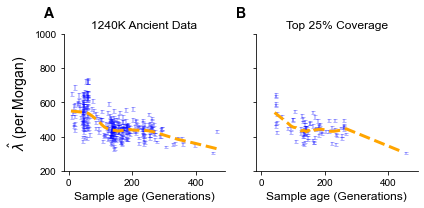

In [13]:
import cartopy
import cartopy.mpl.geoaxes
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

age_gen = test_df.AvgDateGenerations.values.astype(float)
age_years = test_df.AvgDate_calBP.values.astype(float)
marginal_lambda = test_df.scale_marginal.values
marginal_lambda_se = test_df.se_scale_marginal_fd.values

# Axis 1: The real data
im2 = ax[0].errorbar(rand_jitter(age_gen, scale=1e-3), 
                     marginal_lambda, 
                     yerr=2*marginal_lambda_se,  
                     color='blue', linestyle='none', capsize=2, alpha=0.3)

z = lowess(marginal_lambda, rand_jitter(age_gen), frac=1/3)
ax[0].plot(z[:,0], z[:,1], color='orange', lw=3, linestyle='--', zorder=100)

min_cov, max_cov = np.quantile(test_df.Cov_Autosomes.values, 0.75), np.quantile(test_df.Cov_Autosomes.values, 0.55)

# Apply a filtering step here 
test_filt_df = test_df[(test_df.Cov_Autosomes > min_cov)]
cov_auto = test_filt_df['Cov_Autosomes']
print(np.min(cov_auto), np.nanmean(cov_auto), np.nanstd(cov_auto), np.median(cov_auto), cov_auto.size)

age_gen = test_filt_df.AvgDateGenerations.values.astype(float)
marginal_lambda = test_filt_df.scale_marginal.values
marginal_lambda_se = test_filt_df.se_scale_marginal_fd.values

im3 = ax[1].errorbar(rand_jitter(age_gen, scale=1e-3), 
                     marginal_lambda, 
                     yerr=2*marginal_lambda_se,  
                     color='blue', linestyle='none', capsize=2, alpha=0.3)

z = lowess(marginal_lambda, rand_jitter(age_gen), frac=1/3)
ax[1].plot(z[:,0], z[:,1], color='orange', lw=3, linestyle='--', zorder=100)


# Debox all of the axes
debox_all(ax);

# Setting some labeling
ax[0].set_ylim(200,1000)
# ax[0].set_xlim(0,500)
label_multipanel(ax, ['A','B'], fontsize=14, fontweight='bold', xoff=-0.06, yoff=1.2, va='top', ha='right')
ax[0].set_title(r'1240K Ancient Data', fontsize=12)
ax[1].set_title(r'Top 25% Coverage', fontsize=12)

ax[0].set_ylabel(r'$\hat{\lambda}$ (per Morgan)', fontsize=14)
ax[0].set_xlabel('Sample age (Generations)', fontsize=12);
ax[1].set_xlabel('Sample age (Generations)', fontsize=12);
plt.tight_layout()
plt.savefig(supp_figdir + 'copying_rate_demography_chrX_coverage_validation_v2.pdf', dpi=300, bbox_inches='tight')

nan nan nan


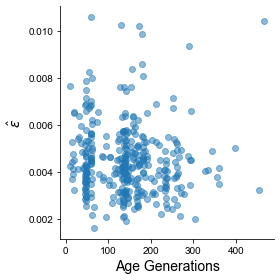

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
r = np.corrcoef(test_df.AvgDateGenerations.values.astype(float), 
              test_df.eps_jt.values.astype(float))[0,1]
se_r = (1.- r**2)/np.sqrt(test_df.shape[0] - 2)
print(r, r-1.96*se_r, r + 1.96*se_r)
ax.scatter(test_df.AvgDateGenerations.values.astype(float), 
              test_df.eps_jt.values.astype(float), alpha=0.5)
ax.set_ylabel(r'$\hat{\epsilon}$', fontsize=14)
ax.set_xlabel(r'Age Generations', fontsize=14)
debox(ax)
plt.tight_layout()
plt.savefig(supp_figdir + 'epsilon_vs_age.pdf', dpi=300, bbox_inches='tight')